In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import os
import sys
import pickle
import matplotlib.cm as cm

path = os.getcwd().split(os.sep + 'GUI')[0]
if path not in sys.path:
    print("not here")
    sys.path.append(path)

import neurolib.dashboard.data as data
from neurolib.models.aln import ALNModel
import neurolib.dashboard.layout as layout
import neurolib.dashboard.functions as functions
from neurolib.utils import plotFunctions as plotFunc

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
readpath = '..' + os.sep

with open(readpath + os.sep + 'bi.pickle','rb') as file:
    load_array= pickle.load(file)
ext_exc = load_array[0]
ext_inh = load_array[1]

grid_resolution = layout.grid_resolution

dist_up_regime = np.zeros((len(ext_exc), 2))
dist_down_regime = np.zeros((len(ext_exc)))

cmap = layout.getcolormap()
darkgrey, midgrey, lightgrey, color_bi_updown, color_LC, color_bi_uposc = layout.getcolors()
exc_red = cmap(3)
inh_blue=cmap(0)
green = cmap(2)

aln = ALNModel()
data.set_parameters(aln)
state_vars = aln.state_vars

In [3]:
readpath = '..' + os.sep

with open(readpath + os.sep + 'bi.pickle','rb') as file:
    load_array= pickle.load(file)
ext_exc = load_array[0]
ext_inh = load_array[1]

grid_resolution = layout.grid_resolution

dist_up_regime = np.zeros((len(ext_exc), 2))
dist_down_regime = np.zeros((len(ext_exc)))

cmap = layout.getcolormap()
darkgrey, midgrey, lightgrey, color_bi_updown, color_LC, color_bi_uposc = layout.getcolors()
exc_red = cmap(3)
inh_blue=cmap(0)
green = cmap(2)

aln = ALNModel()
data.set_parameters(aln)
state_vars = aln.state_vars

In [34]:
##############################################################
def derivative(f,a,dt):
    return (f[a+1] - f[a])/dt

def get_init(exc_, inh_, max_I, model):
    
    initVars_ = [None] * len(exc_)
    
    for i in range(len(exc_)):
        model.params.ext_exc_current = exc_[i] * 5. 
        model.params.ext_inh_current = inh_[i] * 5.

        model.params.duration = 3000.

        control0 = model.getZeroControl()
        control0 = functions.step_control(model, maxI_ = max_I)
        model.run(control=control0)
        
        state_vars = model.state_vars

        init_state_vars = np.zeros(( len(state_vars) ))
        for j in range(len(state_vars)):
            if model.state[state_vars[j]].size == 1:
                init_state_vars[j] = model.state[state_vars[j]][0]
            else:
                init_state_vars[j] = model.state[state_vars[j]][0,-1]

        initVars_[i] = init_state_vars
    
    return initVars_

def setinit(init_vars_, model):
    state_vars = model.state_vars
    init_vars = model.init_vars
    for iv in range(len(init_vars)):
        for sv in range(len(state_vars)):
            if state_vars[sv] in init_vars[iv]:
                #print("set init vars ", )
                if model.params[init_vars[iv]].ndim == 2:
                    model.params[init_vars[iv]][0,:] = init_vars_[sv]
                else:
                    model.params[init_vars[iv]][0] = init_vars_[sv]

def readcase(case_):
    
    global exc_, inh_, no_c_, both_c_
    global exc_1, inh_1, lenx_1, leny_1, exc_2, inh_2, lenx_2, leny_2
    global exc_3, inh_3, lenx_3, leny_3, exc_4, inh_4, lenx_4, leny_4, cost1, cost2, cost3, cost4
    global d_x, d_y, cost_p_x, cost_p_y, cost_s_x, cost_e_x, cost_s_y, cost_e_y
    global d_xy_sum, d_xy, dx3, dy3, cost_xy, cost_xy_sum, costx3, costy3, len3_sum, len3sqrt
    global width_1, width_2, widthx_3, widthy_3, width_4
    global ufp_exc_1, ufp_inh_1, ufp_exc_2, ufp_inh_2
    global ufp, ufp_inh
    
    readpath = '..' + os.sep + 'data_final' + os.sep
    
    data_array = data.read_data(aln, readpath, case_)
    exc_, inh_, both_c_, no_c_ = data_array[0:4]
    exc_1, inh_1, lenx_1, leny_1, exc_2, inh_2, lenx_2, leny_2 = data_array[4:12]
    exc_3, inh_3, lenx_3, leny_3, exc_4, inh_4, lenx_4, leny_4, cost1, cost2, cost3, cost4 = data_array[12:24]
    width_1, width_2, widthx_3, widthy_3, width_4 = data_array[24:29]
    
    print(exc_, inh_, both_c_, no_c_)

    control_data = data.read_control(readpath, case_)
    opt_control = control_data[2]
    opt_state = control_data[3]
        
    d_x = []
    d_y = []
    d_xy_sum = []
    d_xy = []
    dx3 = []
    dy3 = []
    len3_sum = []
    len3sqrt = []
    ufp_exc_1 = []
    ufp_inh_1 = []
    ufp_exc_2 = []
    ufp_inh_2 = []
    
    ufp = np.zeros(( len(exc_) ))
    ufp_inh = np.zeros(( len(exc_) ))
    
    for i in range(len(exc_)):
        
        if type(opt_state[i]) == type(None):
            ufp[i] = -1
            continue
        
        d_state = np.zeros((opt_state[i].shape[2]))
        d_state_inh = np.zeros((opt_state[i].shape[2]))
        for t_ in range(opt_state[i].shape[2] - 1):
            d_state[t_] = derivative(opt_state[i][0,0,:],t_,aln.params.dt)
            d_state_inh[t_] = derivative(opt_state[i][0,1,:],t_,aln.params.dt)

        max1 = np.argmax(d_state[:2500])
        max2 = 2500 + np.argmax(d_state[2500:])

        min1 = max1 + np.argmin(d_state[max1:max2])
        ufp[i] = opt_state[i][0,0,min1]
        
        max1 = np.argmax(d_state_inh[:2500])
        max2 = 2500 + np.argmax(d_state_inh[2500:])

        min1 = max1 + np.argmin(d_state_inh[max1:max2])
        ufp_inh[i] = opt_state[i][0,1,min1]
    
    if case_ in ['1', '2']:
        for i in range(len(exc_1)):
            d_x.append(data.dist_right(exc_1[i], inh_1[i], ext_exc, ext_inh, grid_resolution))
            ufp_exc_1.append(ufp[i])
            ufp_inh_1.append(ufp_inh[i])
        for i in range(len(exc_2)):
            d_y.append(data.dist_low(exc_2[i], inh_2[i], ext_exc, ext_inh, grid_resolution))
            ufp_exc_2.append(ufp[i])
            ufp_inh_2.append(ufp_inh[i])
        for i in range(len(exc_3)):
            dx3.append(data.dist_right(exc_3[i], inh_3[i], ext_exc, ext_inh, grid_resolution))
            dy3.append(data.dist_low(exc_3[i], inh_3[i], ext_exc, ext_inh, grid_resolution))
            d_xy_sum.append(dx3[-1] + dy3[-1])
            len3_sum.append( np.abs(lenx_3[i]) + np.abs(leny_3[i]) )
            d_xy.append( np.sqrt( dx3[-1]**2 + dy3[-1]**2 ) )
            len3sqrt.append( np.sqrt( lenx_3[i]**2 + leny_3[i]**2  ))
    else:
        for i in range(len(exc_1)):
            d_x.append(data.dist_left(exc_1[i], inh_1[i], ext_exc, ext_inh, grid_resolution))
            ufp_exc_1.append(ufp[i])
            ufp_inh_1.append(ufp_inh[i])
        for i in range(len(exc_2)):
            d_y.append(data.dist_up(exc_2[i], inh_2[i], ext_exc, ext_inh, grid_resolution))
            ufp_exc_2.append(ufp[i])
            ufp_inh_2.append(ufp_inh[i])
        for i in range(len(exc_3)):
            dx3.append(data.dist_left(exc_3[i], inh_3[i], ext_exc, ext_inh, grid_resolution))
            dy3.append(data.dist_up(exc_3[i], inh_3[i], ext_exc, ext_inh, grid_resolution))
            d_xy_sum.append(dx3[-1] + dy3[-1])
            len3_sum.append( np.abs(lenx_3[i]) + np.abs(leny_3[i]) )
            d_xy.append( np.sqrt( dx3[-1]**2 + dy3[-1]**2 ) )
            len3sqrt.append( np.sqrt( lenx_3[i]**2 + leny_3[i]**2  ))
        
    cost_p_x = []
    cost_p_y = []
    cost_s_x = []
    cost_e_x = []
    cost_s_y = []
    cost_e_y = []
    
    cost_xy = []
    costx3 = []
    costy3 = []
    cost_xy_sum = []
    

    for i in range(len(d_x)):
        cost_p_x.append(cost1[i][0][0][0])
        cost_s_x.append(cost1[i][2][0][0])
        cost_e_x.append(cost1[i][1][0][0])
    for i in range(len(d_y)):
        cost_p_y.append(cost2[i][0][0][1])
        cost_s_y.append(cost2[i][2][0][1])
        cost_e_y.append(cost2[i][1][0][1])
    for i in range(len(dx3)):
        costx3.append(cost3[i][1][0][0])
        costy3.append(cost3[i][1][0][1])
        cost_xy_sum.append( costx3[-1] + costy3[-1] )
        cost_xy.append( np.sqrt( costx3[-1]**2 + costy3[-1]**2 ) )

case =  ..\data_final 1
[8, 22, 28, 32, 34, 35, 36, 38, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145] [0, 2, 4, 5, 6, 12, 14, 15, 16, 18, 20, 25, 26, 30] [10, 24] []
case =  ..\data_final\ 1
case =  ..\data_final 3
[0, 2, 4, 5, 6, 8, 10, 12, 14, 15, 16, 18, 20, 22, 24, 25, 26, 28, 30, 32, 34, 35, 36, 38, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145] [] [] []
case =  ..\data_final\ 3


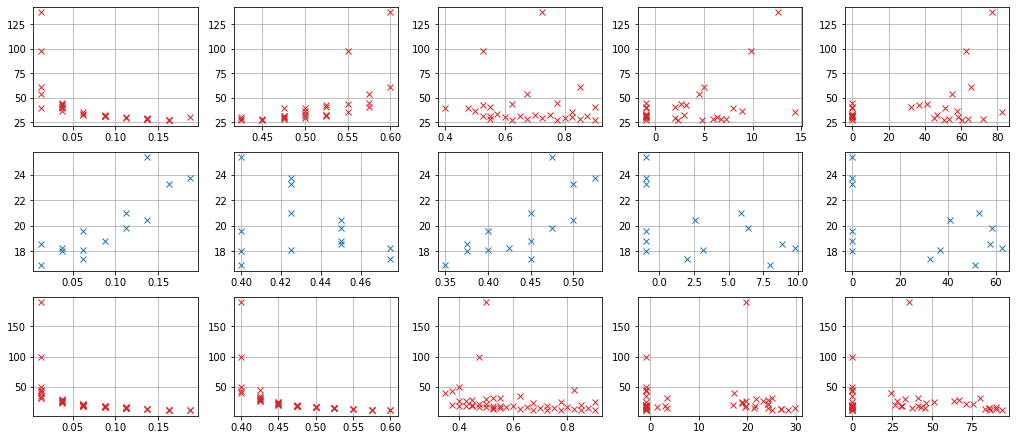

In [33]:
fig5, ax = plt.subplots(3, 5, constrained_layout=True, figsize = (14,6) )
    
readcase('1')

ax[0,0].plot(d_x, width_1, 'x', color=exc_red, markersize=6)
ax[0,1].plot(exc_1, width_1, 'x', color=exc_red, markersize=6)
ax[0,2].plot(inh_1, width_1, 'x', color=exc_red, markersize=6)
ax[0,3].plot(ufp_exc_1, width_1, 'x', color=exc_red, markersize=6)
ax[0,4].plot(ufp_inh_1, width_1, 'x', color=exc_red, markersize=6)

ax[1,0].plot(d_y, width_2, 'x', color=inh_blue, markersize=6)
ax[1,1].plot(exc_2, width_2, 'x', color=inh_blue, markersize=6)
ax[1,2].plot(inh_2, width_2, 'x', color=inh_blue, markersize=6)
ax[1,3].plot(ufp_exc_2, width_2, 'x', color=inh_blue, markersize=6)
ax[1,4].plot(ufp_inh_2, width_2, 'x', color=inh_blue, markersize=6)

readcase('3')

ax[2,0].plot(d_x, width_1, 'x', color=exc_red, markersize=6)
ax[2,1].plot(exc_1, width_1, 'x', color=exc_red, markersize=6)
ax[2,2].plot(inh_1, width_1, 'x', color=exc_red, markersize=6)
ax[2,3].plot(ufp_exc_1, width_1, 'x', color=exc_red, markersize=6)
ax[2,4].plot(ufp_inh_1, width_1, 'x', color=exc_red, markersize=6)

plt.show()

case =  ..\data_final 2
[] [] [0, 2, 4, 5, 6, 8, 10, 12, 14, 15, 16, 18, 20, 22, 24, 25, 26, 28, 30, 32, 34, 35, 36, 38, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145] []
case =  ..\data_final\ 2
case =  ..\data_final 4
[] [] [0, 4, 5, 8, 10, 12, 15, 16, 20, 24, 25, 28, 30, 32, 35, 36, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145] []
case =  ..\data_final\ 4


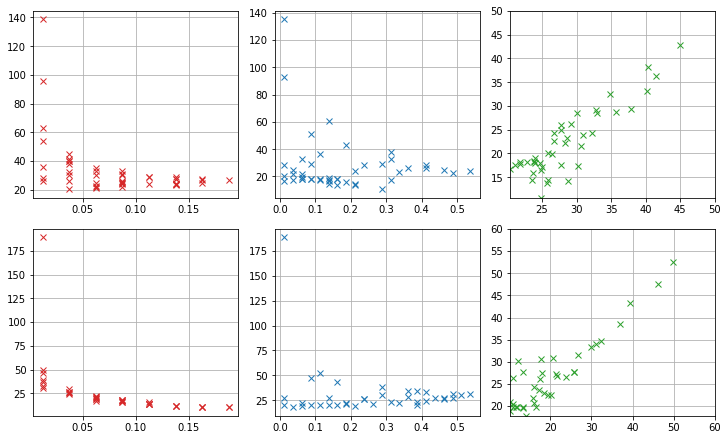

In [49]:
fig5, ax = plt.subplots(2, 3, constrained_layout=True, figsize = (10,6) )
    
readcase('2')

ax[0,0].plot(dx3, widthx_3, 'x', color=exc_red, markersize=6)
ax[0,1].plot(dy3, widthy_3, 'x', color=inh_blue, markersize=6)
ax[0,2].plot(widthx_3, widthy_3, 'x', color=green, markersize=6)
ax[0,2].set_xlim([np.amin(widthx_3), 50.])
ax[0,2].set_ylim([np.amin(widthy_3), 50.])

readcase('4')

ax[1,0].plot(dx3, widthx_3, 'x', color=exc_red, markersize=6)
ax[1,1].plot(dy3, widthy_3, 'x', color=inh_blue, markersize=6)
ax[1,2].plot(widthx_3, widthy_3, 'x', color=green, markersize=6)
ax[1,2].set_xlim([np.amin(widthx_3), 60.])
ax[1,2].set_ylim([np.amin(widthy_3), 60.])

plt.show()

case =  ..\data_final 1
[8, 22, 28, 32, 34, 35, 36, 38, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145] [0, 2, 4, 5, 6, 12, 14, 15, 16, 18, 20, 25, 26, 30] [10, 24] []
case =  ..\data_final\ 1


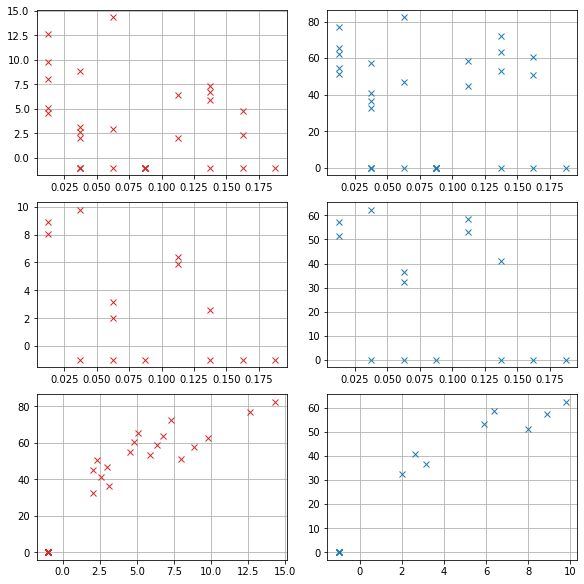

In [17]:
# FIG 16, 18

fig5, ax = plt.subplots(3, 2, constrained_layout=True, figsize = (8,8) )
    
readcase('1')

ax[0,0].plot(d_x, ufp_exc_1, 'x', color=exc_red, markersize=6)
ax[0,1].plot(d_x, ufp_inh_1, 'x', color=inh_blue, markersize=6)
ax[1,0].plot(d_y, ufp_exc_2, 'x', color=exc_red, markersize=6)
ax[1,1].plot(d_y, ufp_inh_2, 'x', color=inh_blue, markersize=6)
ax[2,0].plot(ufp_exc_1, ufp_inh_1, 'x', color=exc_red, markersize=6)
ax[2,1].plot(ufp_exc_2, ufp_inh_2, 'x', color=inh_blue, markersize=6)

plt.show()

case =  ..\data_final\ 1
(20,) 0.2942004025626621
0


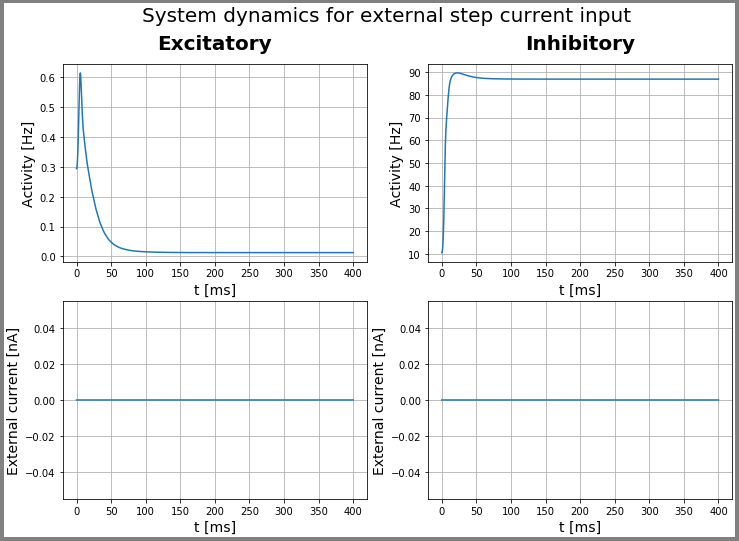

8


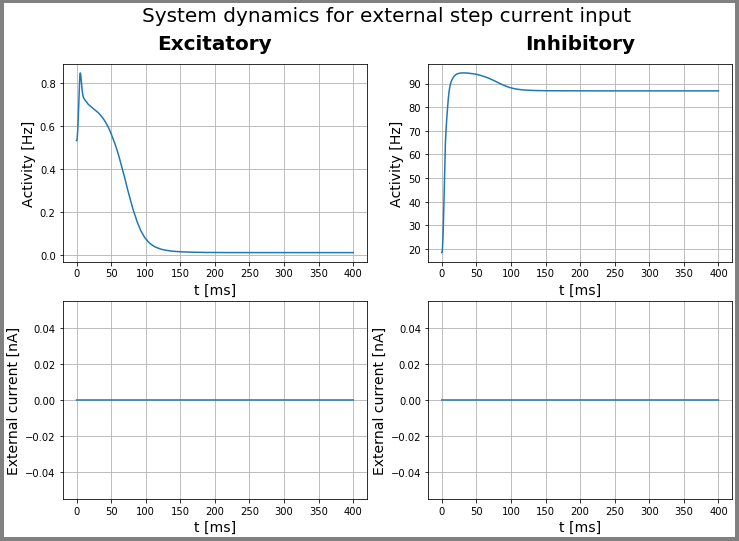

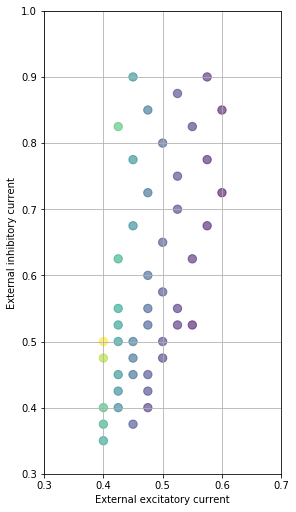

In [6]:
#FIG 1
dur = 400.

case_ = '1'
readpath = '..' + os.sep + 'data_final' + os.sep
control_data = data.read_control(readpath, case_)
opt_control = control_data[2]
opt_state = control_data[3]

i_range = [0,8,16,28]
ufp = np.zeros(( len(ext_exc) ))

init_vars = get_init(ext_exc, ext_inh, -3, aln)

print(init_vars[0].shape, init_vars[0][0])

for i in range(len(ext_exc)):
    
    if type(opt_state[i]) == type(None):
        ufp[i] = -1
        continue
    
    d_state = np.zeros((opt_state[i].shape[2]))
    for t_ in range(opt_state[i].shape[2] - 1):
        d_state[t_] = derivative(opt_state[i][0,0,:],t_,aln.params.dt)

    # look for minimum between two maxima
        
    max1 = np.argmax(d_state[:2500])
    max2 = 2500 + np.argmax(d_state[2500:])
                        
    min1 = max1 + np.argmin(d_state[max1:max2])
    #print("unstable fixed point activity = ", opt_state[i][0,0,min1])
    ufp[i] = opt_state[i][0,0,min1]
    
    
    if i in [0, 8]:
        print(i)
        setinit(init_vars[i], aln)
        aln.params.duration = 400.
        plotFunc.plot_traces_control_current(aln, aln.getZeroControl())
        plt.show()
    
    #fig1, ax = plt.subplots(constrained_layout=True, figsize = (4,4) )
    #ax.plot(np.arange(0,420.1,0.1), d_state, color='blue')
    #ax1 = ax.twinx()
    #ax1.plot(np.arange(0,420.1,0.1), opt_state[i][0,0,:], color='red')
    #plt.show()

    
color_ = np.zeros(( len(ext_exc) ))
cmap_ = ['w'] * len(ext_exc)
cmap=cm.get_cmap('viridis')

color_[:] = ufp[:] / np.amax(ufp)
for c_ in range(len(cmap_)):
    cmap_[c_] = cmap(color_[c_])

for i in range(len(ext_exc)):
    if ufp[i] == -1:
        cmap_[i] = 'w'
        
fig1, ax = plt.subplots(constrained_layout=True, figsize = (4,7) )
ax.scatter(ext_exc, ext_inh, s=70, color=cmap_, alpha=0.6)
ax.set_xlim(0.3, 0.7)
ax.set_ylim(0.3, 1.)

ax.set_xlabel("External excitatory current")
ax.set_ylabel("External inhibitory current")
plt.show()

task 1
case =  1
case =  ..\data_final 1
[8, 22, 28, 32, 34, 35, 36, 38, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145] [0, 2, 4, 5, 6, 12, 14, 15, 16, 18, 20, 25, 26, 30] [10, 24] []
case =  ..\data_final\ 1
task 2
case =  2
case =  ..\data_final 2
[] [] [0, 2, 4, 5, 6, 8, 10, 12, 14, 15, 16, 18, 20, 22, 24, 25, 26, 28, 30, 32, 34, 35, 36, 38, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145] []
case =  ..\data_final\ 2
task 3
case =  3
case =  ..\data_final 3
[0, 2, 4, 5, 6, 8, 10, 12, 14, 15, 16, 18, 20, 22, 24, 25, 26, 28, 30, 32, 34, 35, 36, 38, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145] [] [] []
case =  ..\data_final\ 3
task 4
case =  4
case =  ..\data_final 4
[] [] [0, 4, 5, 8, 10, 12, 15, 16, 20, 24, 25, 28, 30, 32, 35, 36, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145] []
cas

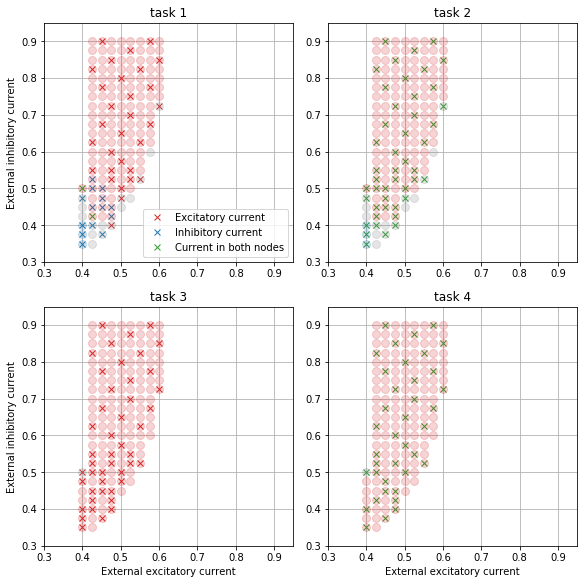

In [7]:
# fig 6, 7, 8, 9

fig7, ax = plt.subplots(2,2, constrained_layout=True, figsize = (8,8) )

titles = [r'task 1', r'task 2', 'task 3', 'task 4']

cases = ['1', '2', '3', '4']

alpha_val = 0.2

for k in range(len(cases)):
    print(titles[k])
    print("case = ", cases[k])
    readcase(cases[k])
    cost_index = np.zeros(( len(ext_exc), 4))
    
    ind_x = 0
    ind_y = 0
    
    if k == 1:
        ind_y = 1
    elif k == 2:
        ind_x = 1
    elif k == 3:
        ind_x = 1
        ind_y = 1

    for i in range(len(ext_exc)):
        cost_index[i,0] = i
        
        for j in range(len(exc_)):
            if exc_[j] == i:
                cost_index[i,1] = cost1[j][0][0][0] + cost1[j][2][0][0]
                #if cost_index[i,1] > 0.:
                #    print("large cost : ", i, ext_exc[i], ext_inh[i], cost_index[i,1])
        for j in range(len(inh_)):
            if inh_[j] == i:
                cost_index[i,2] = cost2[j][0][0][0] + cost2[j][2][0][1]
                #if cost_index[i,2] > 0.:
                #    print("large cost : ", i, ext_exc[i], ext_inh[i], cost_index[i,2])
        for j in range(len(both_c_)):
            if both_c_[j] == i:
                cost_index[i,3] = ( cost3[j][0][0][0] + cost3[j][2][0][0] + cost3[j][2][0][1] )
                #if cost_index[i,3] > 0.:
                #    print("large cost : ", i, ext_exc[i], ext_inh[i], cost_index[i,3])

    for i in range(cost_index.shape[0]):
        
        if cost_index[i,1] != 0. and cost_index[i,2] != 0. and cost_index[i,3] != 0.:
            if cost_index[i,1] < cost_index[i,2] and cost_index[i,1] < cost_index[i,3]:
                ax[ind_x,ind_y].plot(ext_exc[i], ext_inh[i], 'x', color=exc_red)
            elif cost_index[i,2] < cost_index[i,1] and cost_index[i,2] < cost_index[i,3]:
                ax[ind_x,ind_y].plot(ext_exc[i], ext_inh[i], 'x', color=inh_blue)
            elif cost_index[i,3] < cost_index[i,1] and cost_index[i,3] < cost_index[i,2]:
                ax[ind_x,ind_y].plot(ext_exc[i], ext_inh[i], 'x', color=green)
        elif cost_index[i,1] != 0. and cost_index[i,2] != 0.:
            if cost_index[i,1] < cost_index[i,2]:
                ax[ind_x,ind_y].plot(ext_exc[i], ext_inh[i], 'x', color=exc_red)
            elif cost_index[i,2] < cost_index[i,1]:
                ax[ind_x,ind_y].plot(ext_exc[i], ext_inh[i], 'x', color=inh_blue)
        elif cost_index[i,1] != 0. and cost_index[i,3] != 0.:
            if cost_index[i,1] < cost_index[i,3]:
                ax[ind_x,ind_y].plot(ext_exc[i], ext_inh[i], 'x', color=exc_red)
            elif cost_index[i,3] < cost_index[i,1]:
                ax[ind_x,ind_y].plot(ext_exc[i], ext_inh[i], 'x', color=green)
        elif cost_index[i,3] != 0. and cost_index[i,2] != 0.:
            if cost_index[i,3] < cost_index[i,2]:
                ax[ind_x,ind_y].plot(ext_exc[i], ext_inh[i], 'x', color=green)
            elif cost_index[i,2] < cost_index[i,3]:
                ax[ind_x,ind_y].plot(ext_exc[i], ext_inh[i], 'x', color=inh_blue)
        elif cost_index[i,1] != 0.:
            ax[ind_x,ind_y].plot(ext_exc[i], ext_inh[i], 'x', color=exc_red)
        elif cost_index[i,2] != 0.:
            ax[ind_x,ind_y].plot(ext_exc[i], ext_inh[i], 'x', color=inh_blue)
        elif cost_index[i,3] != 0.:
            ax[ind_x,ind_y].plot(ext_exc[i], ext_inh[i], 'x', color=green)


        dist_x = data.dist_right(ext_exc[i], ext_inh[i], ext_exc, ext_inh, grid_resolution)
        dist_y = data.dist_low(ext_exc[i], ext_inh[i], ext_exc, ext_inh, grid_resolution)

        if k == 0 or k == 1:
            if (dist_x - dist_y) < - 1e-4:
                ax[ind_x,ind_y].plot(ext_exc[i], ext_inh[i], 'o', alpha=alpha_val, markersize=8, color=exc_red)
            elif (dist_x - dist_y) > 1e-4:
                ax[ind_x,ind_y].plot(ext_exc[i], ext_inh[i], 'o', alpha=alpha_val, markersize=8, color=inh_blue)
            else:
                #print("apparently same distance: ", i, dist_x, dist_y)
                ax[ind_x,ind_y].plot(ext_exc[i], ext_inh[i], 'o', alpha=alpha_val, markersize=8, color='grey')
        else:
            if i == 24:
                ax[ind_x,ind_y].plot(ext_exc[i], ext_inh[i], 'o', alpha=alpha_val, markersize=8, color='grey')
            else:
                ax[ind_x,ind_y].plot(ext_exc[i], ext_inh[i], 'o', alpha=alpha_val, markersize=8, color=exc_red)

    ax[ind_x,ind_y].set_xlim(0.3, 0.95)
    ax[ind_x,ind_y].set_ylim(0.3, 0.95)
    
    ax[ind_x,ind_y].set_title(titles[k])   
            
ax[1,0].set_xlabel("External excitatory current")
ax[1,1].set_xlabel("External excitatory current")
ax[0,0].set_ylabel("External inhibitory current")
ax[1,0].set_ylabel("External inhibitory current")

legend_elements = [Line2D([], [], color=exc_red, marker='x', linestyle='None', label='Excitatory current'),
                  Line2D([], [], color=inh_blue, marker='x', linestyle='None', label='Inhibitory current'),
                  Line2D([], [], color=green, marker='x', linestyle='None', label='Current in both nodes')]

ax[0,0].legend(handles=legend_elements)
    
plt.savefig(os.path.join(os.getcwd(), 'FIG_6_7_8_9'))

#print(exc_, inh_, both_c_, no_c_)

case =  ..\data_final 1
[8, 22, 28, 32, 34, 35, 36, 38, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145] [0, 2, 4, 5, 6, 12, 14, 15, 16, 18, 20, 25, 26, 30] [10, 24] []
case =  ..\data_final\ 1
case =  ..\data_final 3
[0, 2, 4, 5, 6, 8, 10, 12, 14, 15, 16, 18, 20, 22, 24, 25, 26, 28, 30, 32, 34, 35, 36, 38, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145] [] [] []
case =  ..\data_final\ 3


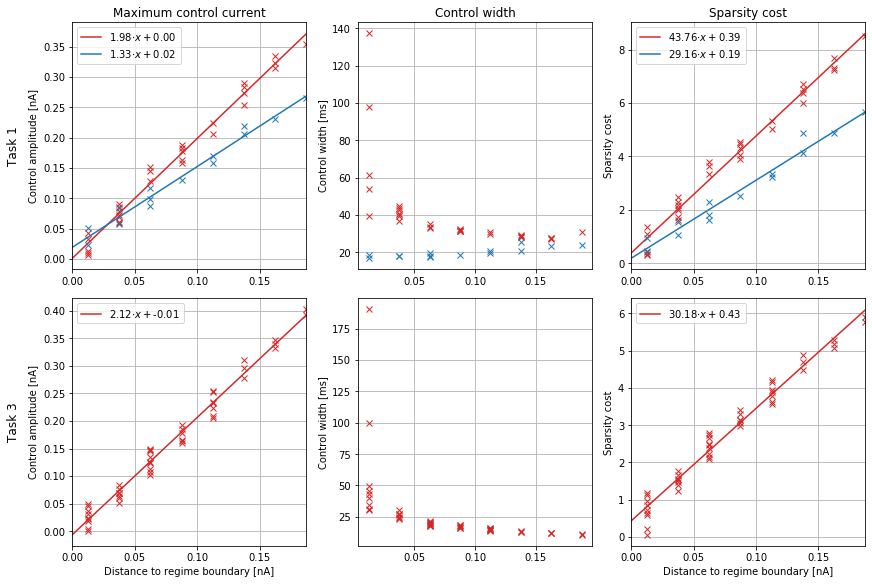

In [8]:
# FIG 16, 18

fig5, ax = plt.subplots(2, 3, constrained_layout=True, figsize = (12,8) )

fit_params = np.zeros((2,2,2,2))
    
readcase('1')

fit_params[0,0,0,0], fit_params[0,0,0,1] = np.polyfit(d_x, np.abs(lenx_1), 1)
fit_params[0,0,1,0], fit_params[0,0,1,1] = np.polyfit(d_y, np.abs(leny_2), 1)
fit_params[0,1,0,0], fit_params[0,1,0,1] = np.polyfit(d_x, cost_s_x, 1)
fit_params[0,1,1,0], fit_params[0,1,1,1] = np.polyfit(d_y, cost_s_y, 1)

x_ = np.arange(0., np.amax(d_x) + 0.001, 0.001)

ax[0,0].plot(d_x, np.abs(lenx_1), 'x', color=exc_red, markersize=6)
ax[0,0].plot(x_, fit_params[0,0,0,0]*x_ + fit_params[0,0,0,1], color=exc_red,
             label='{:.2f}'.format(fit_params[0,0,0,0]) + r'$\cdot x + $' + '{:.2f}'.format(fit_params[0,0,0,1]))
ax[0,0].plot(d_y, np.abs(leny_2), 'x', color=inh_blue, markersize=6)
ax[0,0].plot(x_, fit_params[0,0,1,0]*x_ + fit_params[0,0,1,1], color=inh_blue,
             label='{:.2f}'.format(fit_params[0,0,1,0]) + r'$\cdot x + $' + '{:.2f}'.format(fit_params[0,0,1,1]))
ax[0,1].plot(d_x, width_x, 'x', color=exc_red, markersize=6)
ax[0,1].plot(d_y, width_y, 'x', color=inh_blue, markersize=6)
ax[0,2].plot(d_x, cost_s_x, 'x', color=exc_red, markersize=6)
ax[0,2].plot(x_, fit_params[0,1,0,0]*x_ + fit_params[0,1,0,1], color=exc_red,
             label='{:.2f}'.format(fit_params[0,1,0,0]) + r'$\cdot x + $' + '{:.2f}'.format(fit_params[0,1,0,1]))
ax[0,2].plot(d_y, cost_s_y, 'x', color=inh_blue, markersize=6)
ax[0,2].plot(x_, fit_params[0,1,1,0]*x_ + fit_params[0,1,1,1], color=inh_blue,
             label='{:.2f}'.format(fit_params[0,1,1,0]) + r'$\cdot x + $' + '{:.2f}'.format(fit_params[0,1,1,1]))

ax[0,0].set_xlim([0., np.amax(d_x)])
ax[0,2].set_xlim([0., np.amax(d_x)])
ax[0,0].legend()
ax[0,2].legend()

readcase('3')

fit_params[1,0,0,0], fit_params[1,0,0,1] = np.polyfit(d_x, np.abs(lenx_1), 1)
#fit_params[1,0,1,0], fit_params[1,0,1,1] = np.polyfit(d_y, np.abs(leny_2), 1)
fit_params[1,1,0,0], fit_params[1,1,0,1] = np.polyfit(d_x, cost_s_x, 1)
#fit_params[1,1,1,0], fit_params[1,1,1,1] = np.polyfit(d_y, cost_s_y, 1)

ax[1,0].plot(d_x, np.abs(lenx_1), 'x', color=exc_red, markersize=6)
ax[1,0].plot(x_, fit_params[1,0,0,0]*x_ + fit_params[1,0,0,1], color=exc_red,
             label='{:.2f}'.format(fit_params[1,0,0,0]) + r'$\cdot x + $' + '{:.2f}'.format(fit_params[1,0,0,1]))
ax[1,0].plot(d_y, np.abs(leny_2), 'x', color=inh_blue, markersize=6)
#ax[1,0].plot(x_, fit_params[1,0,1,0]*x_ + fit_params[1,0,1,1], color=inh_blue,
#             label='{:.2f}'.format(fit_params[1,0,1,0]) + r'$\cdot x + $' + '{:.2f}'.format(fit_params[1,0,1,1]))
ax[1,1].plot(d_x, width_x, 'x', color=exc_red, markersize=6)
ax[1,1].plot(d_y, width_y, 'x', color=inh_blue, markersize=6)
ax[1,2].plot(d_x, cost_s_x, 'x', color=exc_red, markersize=6)
ax[1,2].plot(x_, fit_params[1,1,0,0]*x_ + fit_params[1,1,0,1], color=exc_red,
             label='{:.2f}'.format(fit_params[1,1,0,0]) + r'$\cdot x + $' + '{:.2f}'.format(fit_params[1,1,0,1]))
ax[1,2].plot(d_y, cost_s_y, 'x', color=inh_blue, markersize=6)
#ax[1,2].plot(x_, fit_params[1,1,1,0]*x_ + fit_params[1,1,1,1], color=inh_blue,
#             label='{:.2f}'.format(fit_params[1,1,1,0]) + r'$\cdot x + $' + '{:.2f}'.format(fit_params[1,1,1,1]))

ax[1,0].set_xlabel("Distance to regime boundary [nA]")
ax[1,2].set_xlabel("Distance to regime boundary [nA]")
ax[0,0].set_ylabel("Control amplitude [nA]")
ax[1,0].set_ylabel("Control amplitude [nA]")
ax[0,1].set_ylabel("Control width [ms]")
ax[1,1].set_ylabel("Control width [ms]")
ax[0,2].set_ylabel("Sparsity cost")
ax[1,2].set_ylabel("Sparsity cost")

ax[1,0].set_xlim([0., np.amax(d_x)])
ax[1,2].set_xlim([0., np.amax(d_x)])
ax[1,0].legend()
ax[1,2].legend()

cols = ['Maximum control current', 'Control width', 'Sparsity cost']
rows = ['Task 1', 'Task 3']

pad = 5 # in points

for ax_, col in zip(ax[0], cols):
    ax_.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax_, row in zip(ax[:,0], rows):
    ax_.annotate(row, xy=(0, 0.5), xytext=(-ax_.yaxis.labelpad - pad, 0),
                xycoords=ax_.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center', rotation=90)

plt.savefig( os.path.join(os.getcwd(), 'FIG_16_18') )
plt.show()

case =  ..\data_final 2
[] [] [0, 4, 5, 8, 10, 12, 15, 16, 20, 24, 25, 28, 30, 32, 35, 36, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145] []
case =  ..\data_final\ 2
case =  ..\data_final 4
[] [] [0, 4, 5, 8, 10, 12, 15, 16, 20, 24, 25, 28, 30, 32, 35, 36, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145] []
case =  ..\data_final\ 4


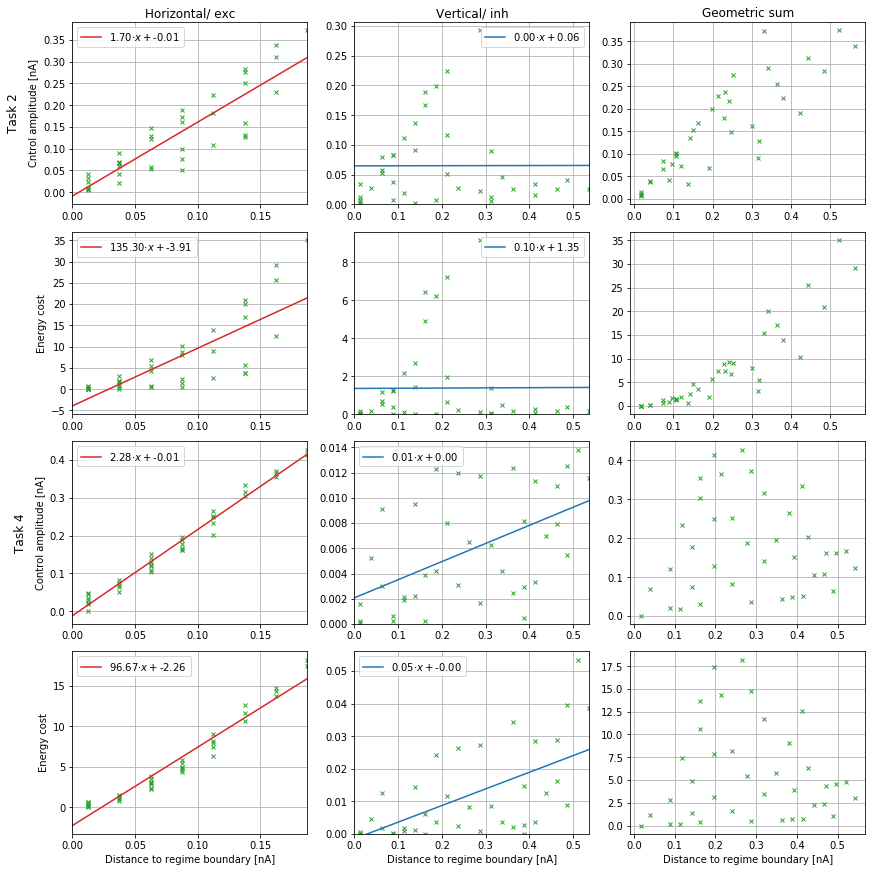

In [6]:
fig5b, ax = plt.subplots(4,3, constrained_layout=True, figsize = (12,12) )

#########################################
readcase('2')

fit_params = np.zeros((2,2,2,2))
x1_ = np.arange(0., np.amax(dx3) + 0.001, 0.001)
x2_ = np.arange(0., np.amax(dy3) + 0.001, 0.001)

fit_params[0,0,0,0], fit_params[0,0,0,1] = np.polyfit(dx3, np.abs(lenx_3), 1)
fit_params[0,0,1,0], fit_params[0,0,1,1] = np.polyfit(dy3, np.abs(leny_3), 1)
fit_params[0,1,0,0], fit_params[0,1,0,1] = np.polyfit(dx3, costx3, 1)
fit_params[0,1,1,0], fit_params[0,1,1,1] = np.polyfit(dy3, costy3, 1)

ax[0,0].plot(dx3, np.abs(lenx_3), 'x', color=green, markersize=4)
ax[0,0].plot(x1_, fit_params[0,0,0,0]*x1_ + fit_params[0,0,0,1], color=exc_red,
             label='{:.2f}'.format(fit_params[0,0,0,0]) + r'$\cdot x + $' + '{:.2f}'.format(fit_params[0,0,0,1]))
#ax[0,0].plot(x1_, fit_params[0,0,1,0]*x1_ + fit_params[0,0,1,1], color=inh_blue,
#             label='{:.2f}'.format(fit_params[0,0,1,0]) + r'$\cdot x + $' + '{:.2f}'.format(fit_params[0,0,1,1]))
ax[0,1].plot(dy3, np.abs(leny_3), 'x', color=green, markersize=4)
#ax[0,1].plot(x2_, fit_params[0,0,0,0]*x2_ + fit_params[0,0,0,1], color=exc_red,
#             label='{:.2f}'.format(fit_params[0,0,0,0]) + r'$\cdot x + $' + '{:.2f}'.format(fit_params[0,0,0,1]))
ax[0,1].plot(x2_, fit_params[0,0,1,0]*x2_ + fit_params[0,0,1,1], color=inh_blue,
             label='{:.2f}'.format(fit_params[0,0,1,0]) + r'$\cdot x + $' + '{:.2f}'.format(fit_params[0,0,1,1]))
ax[0,2].plot(d_xy, len3sqrt, 'x', color=green, markersize=4)
    
ax[1,0].plot(dx3, costx3, 'x', color=green, markersize=4)
ax[1,0].plot(x1_, fit_params[0,1,0,0]*x1_ + fit_params[0,1,0,1], color=exc_red,
             label='{:.2f}'.format(fit_params[0,1,0,0]) + r'$\cdot x + $' + '{:.2f}'.format(fit_params[0,1,0,1]))
#ax[1,0].plot(x1_, fit_params[0,1,1,0]*x1_ + fit_params[0,1,1,1], color=inh_blue,
#             label='{:.2f}'.format(fit_params[0,1,1,0]) + r'$\cdot x + $' + '{:.2f}'.format(fit_params[0,1,1,1]))
ax[1,1].plot(dy3, costy3, 'x', color=green, markersize=4)
#ax[1,1].plot(x2_, fit_params[0,1,0,0]*x2_ + fit_params[0,1,0,1], color=exc_red,
#             label='{:.2f}'.format(fit_params[0,1,0,0]) + r'$\cdot x + $' + '{:.2f}'.format(fit_params[0,1,0,1]))
ax[1,1].plot(x2_, fit_params[0,1,1,0]*x2_ + fit_params[0,1,1,1], color=inh_blue,
             label='{:.2f}'.format(fit_params[0,1,1,0]) + r'$\cdot x + $' + '{:.2f}'.format(fit_params[0,1,1,1]))
ax[1,2].plot(d_xy, cost_xy, 'x', color=green, markersize=4)

ax[0,0].set_xlim([0., np.amax(dx3)])
ax[0,1].set_xlim([0., np.amax(dy3)])
ax[0,1].set_ylim([0., 1.05 * np.amax(np.abs(leny_3))])
ax[1,0].set_xlim([0., np.amax(dx3)])
ax[1,1].set_xlim([0., np.amax(dy3)])
ax[1,1].set_ylim([0., 1.05 * np.amax(costy3)])
ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()


readcase('4')

x1_ = np.arange(0., np.amax(dx3) + 0.001, 0.001)
x2_ = np.arange(0., np.amax(dy3) + 0.001, 0.001)

fit_params[1,0,0,0], fit_params[1,0,0,1] = np.polyfit(dx3, np.abs(lenx_3), 1)
fit_params[1,0,1,0], fit_params[1,0,1,1] = np.polyfit(dy3, np.abs(leny_3), 1)
fit_params[1,1,0,0], fit_params[1,1,0,1] = np.polyfit(dx3, costx3, 1)
fit_params[1,1,1,0], fit_params[1,1,1,1] = np.polyfit(dy3, costy3, 1)

ax[2,0].plot(dx3, np.abs(lenx_3), 'x', color=green, markersize=4)
ax[2,0].plot(x1_, fit_params[1,0,0,0]*x1_ + fit_params[1,0,0,1], color=exc_red,
             label='{:.2f}'.format(fit_params[1,0,0,0]) + r'$\cdot x + $' + '{:.2f}'.format(fit_params[1,0,0,1]))
#ax[2,0].plot(x1_, fit_params[1,0,1,0]*x1_ + fit_params[1,0,1,1], color=inh_blue,
#             label='{:.2f}'.format(fit_params[1,0,1,0]) + r'$\cdot x + $' + '{:.2f}'.format(fit_params[1,0,1,1]))
ax[2,1].plot(dy3, np.abs(leny_3), 'x', color=green, markersize=4)
#ax[2,1].plot(x2_, fit_params[1,0,0,0]*x2_ + fit_params[1,0,0,1], color=exc_red,
#             label='{:.2f}'.format(fit_params[1,0,0,0]) + r'$\cdot x + $' + '{:.2f}'.format(fit_params[1,0,0,1]))
ax[2,1].plot(x2_, fit_params[1,0,1,0]*x2_ + fit_params[1,0,1,1], color=inh_blue,
             label='{:.2f}'.format(fit_params[1,0,1,0]) + r'$\cdot x + $' + '{:.2f}'.format(fit_params[1,0,1,1]))
ax[2,2].plot(d_xy, len3sqrt, 'x', color=green, markersize=4)
    
ax[3,0].plot(dx3, costx3, 'x', color=green, markersize=4)
ax[3,0].plot(x1_, fit_params[1,1,0,0]*x1_ + fit_params[1,1,0,1], color=exc_red,
             label='{:.2f}'.format(fit_params[1,1,0,0]) + r'$\cdot x + $' + '{:.2f}'.format(fit_params[1,1,0,1]))
#ax[3,0].plot(x1_, fit_params[1,1,1,0]*x1_ + fit_params[1,1,1,1], color=inh_blue,
#             label='{:.2f}'.format(fit_params[1,1,1,0]) + r'$\cdot x + $' + '{:.2f}'.format(fit_params[1,1,1,1]))
ax[3,1].plot(dy3, costy3, 'x', color=green, markersize=4)
#ax[3,1].plot(x2_, fit_params[1,1,0,0]*x2_ + fit_params[1,1,0,1], color=exc_red,
#             label='{:.2f}'.format(fit_params[1,1,0,0]) + r'$\cdot x + $' + '{:.2f}'.format(fit_params[1,1,0,1]))
ax[3,1].plot(x2_, fit_params[1,1,1,0]*x2_ + fit_params[1,1,1,1], color=inh_blue,
             label='{:.2f}'.format(fit_params[1,1,1,0]) + r'$\cdot x + $' + '{:.2f}'.format(fit_params[1,1,1,1]))
ax[3,2].plot(d_xy, cost_xy, 'x', color=green, markersize=4)

ax[2,0].set_xlim([0., np.amax(dx3)])
ax[2,1].set_xlim([0., np.amax(dy3)])
ax[2,1].set_ylim([0., 1.05 * np.amax(np.abs(leny_3))])
ax[3,0].set_xlim([0., np.amax(dx3)])
ax[3,1].set_xlim([0., np.amax(dy3)])
ax[3,1].set_ylim([0., 1.05 * np.amax(costy3)])
ax[2,0].legend()
ax[2,1].legend()
ax[3,0].legend()
ax[3,1].legend()

ax[3,0].set_xlabel("Distance to regime boundary [nA]")
ax[3,1].set_xlabel("Distance to regime boundary [nA]")
ax[3,2].set_xlabel("Distance to regime boundary [nA]")
ax[0,0].set_ylabel("Cntrol amplitude [nA]")
ax[1,0].set_ylabel("Energy cost")
ax[2,0].set_ylabel("Control amplitude [nA]")
ax[3,0].set_ylabel("Energy cost")


cols = ['Horizontal/ exc', 'Vertical/ inh', 'Geometric sum']
rows = ['Task 2', '', 'Task 4', '']

pad = 5 # in points

for ax_, col in zip(ax[0], cols):
    ax_.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax_, row in zip(ax[:,0], rows):
    ax_.annotate(row, xy=(0, 0.5), xytext=(-ax_.yaxis.labelpad - pad, 0),
                xycoords=ax_.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center', rotation=90)

plt.savefig( os.path.join(os.getcwd(), 'FIG_17_19.png') )
plt.show()